In [28]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy
import SimpleITK as sitk


In [29]:
def polydata_to_imagedata(polydata, dimensions=(100, 100, 100), padding=1):
    '''
    https://github.com/tfmoraes/polydata_to_imagedata/blob/main/polydata_to_imagedata.py
    '''
    xi, xf, yi, yf, zi, zf = polydata.GetBounds()
    dx, dy, dz = dimensions

    # Calculating spacing
    sx = (xf - xi) / dx
    sy = (yf - yi) / dy
    sz = (zf - zi) / dz

    # Calculating Origin
    ox = xi + sx / 2.0
    oy = yi + sy / 2.0
    oz = zi + sz / 2.0

    if padding:
        ox -= sx
        oy -= sy
        oz -= sz

        dx += 2 * padding
        dy += 2 * padding
        dz += 2 * padding

    image = vtk.vtkImageData()
    image.SetSpacing((sx, sy, sz))
    image.SetDimensions((dx, dy, dz))
    image.SetExtent(0, dx - 1, 0, dy - 1, 0, dz - 1)
    image.SetOrigin((ox, oy, oz))
    image.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)

    inval = 1
    outval = 0

    for i in range(image.GetNumberOfPoints()):
        image.GetPointData().GetScalars().SetTuple1(i, inval)

    pol2stenc = vtk.vtkPolyDataToImageStencil()
    pol2stenc.SetInputData(polydata)
    pol2stenc.SetOutputOrigin((ox, oy, oz))
    pol2stenc.SetOutputSpacing((sx, sy, sz))
    pol2stenc.SetOutputWholeExtent(image.GetExtent())
    pol2stenc.Update()

    imgstenc = vtk.vtkImageStencil()
    imgstenc.SetInputData(image)
    imgstenc.SetStencilConnection(pol2stenc.GetOutputPort())
    imgstenc.ReverseStencilOff()
    imgstenc.SetBackgroundValue(outval)
    imgstenc.Update()

    return imgstenc.GetOutput()

def vtk2numpy(imvtk):
    """turns a vtk image data into a numpy array"""
    dim = imvtk.GetDimensions()
    data = imvtk.GetPointData().GetScalars()
    imnp = vtk_to_numpy(data)
    # vtk and numpy have different array conventions
    imnp = imnp.reshape(dim[2], dim[1], dim[0])
    imnp = imnp.transpose(2, 1, 0)
    return imnp

def dice_coefficient(truth, prediction):
    intersection = np.logical_and(truth, prediction)
    return 1 - 2. * intersection.sum() / (truth.sum() + prediction.sum())

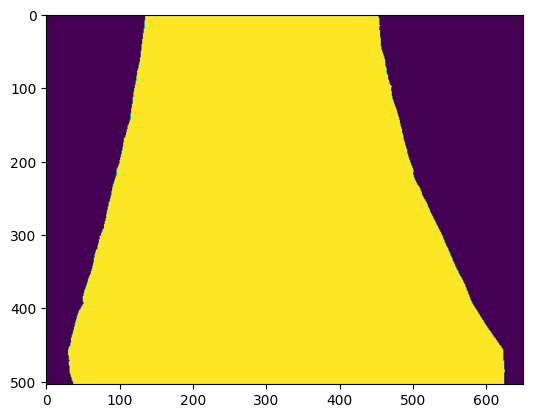

In [30]:
# read masks and sum them together
cort_mask = sitk.ReadImage('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/01_DATA/446_R_75_F/C0003091_CORTMASK.mhd')
trab_mask = sitk.ReadImage('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/01_DATA/446_R_75_F/C0003091_TRABMASK.mhd')
mask_sitk = cort_mask + trab_mask
mask_np = sitk.GetArrayFromImage(mask_sitk)
mask_np = np.flip(mask_np, axis=1)

plt.figure()
plt.imshow(mask_np[:,:,250])
plt.show()

In [31]:
mesh_p = '/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/03_MESH/C0003091sweep_1/C0003091sweep_1.vtk'
mesh = pv.read(mesh_p)
mesh['density'] = np.full(mesh.n_cells, 1)
mesh_grid = pv.create_grid(mesh, dimensions=(mask_np.shape[2], mask_np.shape[1], mask_np.shape[0]))
mesh_res = mesh_grid.sample(mesh)

In [32]:
density_data = mesh_res.get_array(name="density")
density_data_3d = density_data.reshape([mask_np.shape[0], mask_np.shape[1], mask_np.shape[2]])

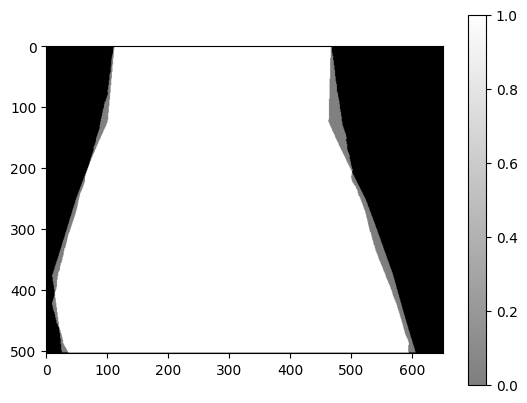

In [33]:
mask_np = np.where(mask_np > 0, 1, 0)
density_data_3d = np.where(density_data_3d > 0, 1, 0)

plt.figure()
plt.imshow(mask_np[:,:,mask_np.shape[2] // 2], cmap='gray')
plt.imshow(density_data_3d[:,:,mask_np.shape[2] // 2], cmap='gray', alpha=0.5)
plt.colorbar()
plt.show()

In [34]:
mask_sitk = sitk.GetImageFromArray(mask_np)
mesh_sitk = sitk.GetImageFromArray(density_data_3d)
mask_sitk.CopyInformation(mask_sitk)
mesh_sitk.CopyInformation(mask_sitk)

meas = sitk.LabelOverlapMeasuresImageFilter()
meas.Execute(mask_sitk, mesh_sitk)
dice = meas.GetDiceCoefficient()
print(dice)

0.9571320008582366
